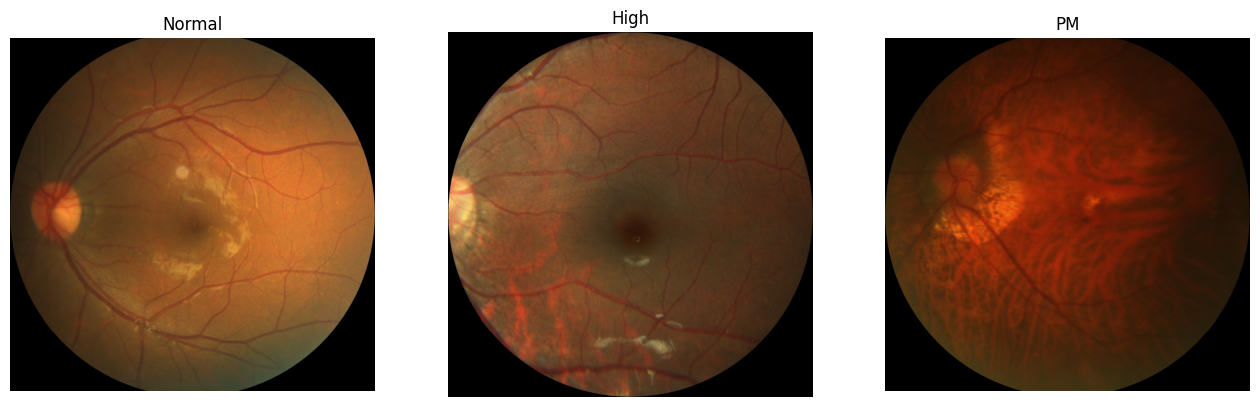

In [12]:
#显示问题图片和正常图片区别
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
p_img = Image.open('/kaggle/input/ichallenge-pm/iChallenge-PM/training/PALM-Training400/PALM-Training400/PALM-Training400/P0074.jpg')
n_img = Image.open('/kaggle/input/ichallenge-pm/iChallenge-PM/training/PALM-Training400/PALM-Training400/PALM-Training400/N0001.jpg')
h_img = Image.open('/kaggle/input/ichallenge-pm/iChallenge-PM/training/PALM-Training400/PALM-Training400/PALM-Training400/H0001.jpg')

plt.figure(figsize=(16,8))
# fig,axes=plt.subplots(2,2)
# ax1=axes[0,0]
# ax2=axes[0,1]
# ax3=axes[1,0]
# ax4=axes[1,1]
f = plt.subplot(131)
f.set_title('Normal')
plt.imshow(n_img)
plt.axis('off')
f = plt.subplot(132)
f.set_title('High')
plt.imshow(h_img)
plt.axis('off')
f = plt.subplot(133)
f.set_title('PM')
plt.imshow(p_img)
plt.axis('off')
plt.show()

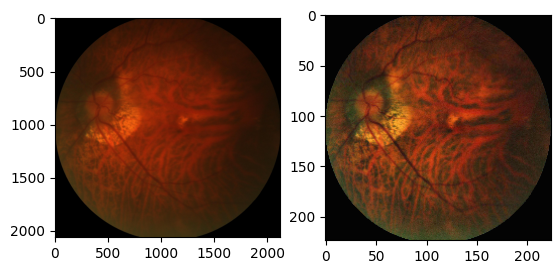

In [13]:
#使用clahe（限制对比度自适应直方图均衡化）增强图像的对比度同时能够抑制噪声,特别适用于医学、红外图像的处理。
import cv2
import numpy as np
def clahe_img(img):

    b,g,r = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    b = clahe.apply(b)
    g = clahe.apply(g)
    r = clahe.apply(r)
    image = cv2.merge([r,g,b])
    return image
filepath = '/kaggle/input/ichallenge-pm/iChallenge-PM/training/PALM-Training400/PALM-Training400/PALM-Training400/P0074.jpg'
img = cv2.imread(filepath,cv2.IMREAD_COLOR)
img2 = clahe_img(img)
img2 = cv2.resize(img2, (224,224))
f = plt.subplot(121)
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)
f = plt.subplot(122)
plt.imshow(img2)
plt.show()

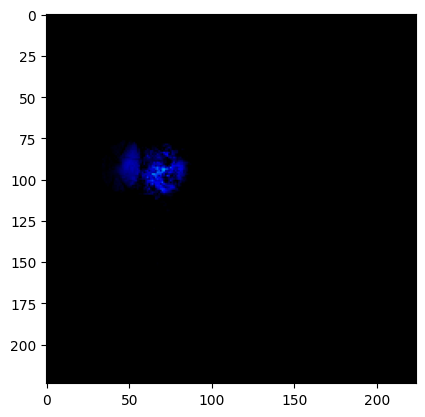

(10, 3, 224, 224) (10, 1)


In [14]:
#定义数据读取器
import os
import random
import cv2
def transform_img(img):
    img = clahe_img(img)
    # img = image_augment_imgauglib(img)
    img = cv2.resize(img, (224,224))
    # 读入的图像数据格式是[H, W, C]
    # 使用转置操作将其变成[C, H, W]
    img = np.transpose(img, (2,0,1))
    img = img.astype('float32')
    # 将数据范围调整到[-1.0, 1.0]之间
    img = img / 255.
    img = img * 2.0 - 1.0
    return img

# 定义训练集数据读取器
def data_loader(datadir, batch_size=10, mode = 'train'):
    # 将datadir目录下的文件列出来，每条文件都要读入
    filenames = os.listdir(datadir)
    def reader():
        cnt=0
        if mode == 'train':
            # 训练时随机打乱数据顺序
            random.shuffle(filenames)
        batch_imgs = []
        batch_labels = []
#         print(filenames)
        for name in filenames:
                filepath = os.path.join(datadir, name)
#                 if cnt<5:
#                     cnt+=1
#                     print(filepath)
                img = cv2.imread(filepath)
#                 plt.imshow(img)
                img = transform_img(img)
                if name[0] == 'H' or name[0] == 'N':
                    # H开头的文件名表示高度近似，N开头的文件名表示正常视力
                    # 高度近视和正常视力的样本，都不是病理性的，属于负样本，标签为0
                    label = 0
                elif name[0] == 'P':
                    # P开头的是病理性近视，属于正样本，标签为1
                    label = 1
                else:
                    raise('Not excepted file name')
                # 每读取一个样本的数据，就将其放入数据列表中
                batch_imgs.append(img)
                batch_labels.append(label)
                if len(batch_imgs) == batch_size:
                    # 当数据列表的长度等于batch_size的时候，
                    # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
                    imgs_array = np.array(batch_imgs).astype('float32')
                    labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                    yield imgs_array, labels_array
                    batch_imgs = []
                    batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader
# 定义验证集数据读取器
def valid_data_loader(datadir, csvfile, batch_size=10, mode='valid'):
    # 训练集读取时通过文件名来确定样本标签，验证集则通过csvfile来读取每个图片对应的标签
    # 请查看解压后的验证集标签数据，观察csvfile文件里面所包含的内容
    # csvfile文件所包含的内容格式如下，每一行代表一个样本，
    # 其中第一列是图片id，第二列是文件名，第三列是图片标签，
    # 第四列和第五列是Fovea的坐标，与分类任务无关
    # ID,imgName,Label,Fovea_X,Fovea_Y
    # 1,V0001.jpg,0,1157.74,1019.87
    # 2,V0002.jpg,1,1285.82,1080.47
    # 打开包含验证集标签的csvfile，并读入其中的内容
    filelists = open(csvfile, encoding='utf8').readlines()
    print('len',len(filelists))
    def reader():
        batch_imgs = []
        batch_labels = []
        for line in filelists[1:]:
            line = line.strip().split(',')
            if len(line[1])==0:
#                 print(line)
                continue
            name = line[1]
            label = int(line[2])
            # 根据图片文件名加载图片，并对图像数据作预处理
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            # 每读取一个样本的数据，就将其放入数据列表中
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                # 当数据列表的长度等于batch_size的时候，
                # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader
#测试
# 查看数据形状
DATADIR = '/kaggle/input/ichallenge-pm/iChallenge-PM/training/PALM-Training400/PALM-Training400/PALM-Training400'
train_loader = data_loader(DATADIR, batch_size=10, mode='train')
data_reader = train_loader()
data = next(data_reader)
plt.figure()
plt.imshow(np.transpose(data[0][1],(1,2,0)))
plt.show()
x_data, y_data = data
print(x_data.shape,y_data.shape)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self, num_classes=1):
        super(LeNet, self).__init__()
        # 创建卷积和池化层块,每个卷积层使用ReLU激活函数,后面跟着一个2x2的最大池化
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 创建第3个卷积层
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=4)
        # 创建全连接层,第一个全连接层有64个输出神经元,第二个全连接层输出神经元个数为分类标签的类别数
        self.fc1 = nn.Linear(in_features=300000, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = torch.reshape(x, [x.shape[0], -1]) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

In [16]:
def draw_acc(x, acc_epoch):
    plt.figure(figsize=(8, 6))
    plt.plot(x, acc_epoch)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Loss Curve')

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#定义训练过程
DATADIR = '/kaggle/input/ichallenge-pm/iChallenge-PM/training/PALM-Training400/PALM-Training400/PALM-Training400'
DATADIR2 = '/kaggle/input/ichallenge-pm/iChallenge-PM/validation/PALM-Validation400'
CSVFILE = '/kaggle/input/pm-gt-label/pm_label_location.csv'
def train(model, save_name):
#     with torch.no_grad():
    print('start training..')
    model.train()
    epoch_num = 20
    opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    train_loader = data_loader(DATADIR, batch_size=10, mode='train')
    valid_loader = valid_data_loader(DATADIR2, CSVFILE)
    loss_epoch=[]
    acc_epoch=[]
    for epoch in range(epoch_num):
        for batch_id, data in enumerate(train_loader()):
            x_data, y_data = data
#             print('batch_id is ', batch_id)
            img = torch.tensor(x_data).cuda()
            label = torch.tensor(y_data).cuda()
            # 运行模型前向计算，得到预测值
            logits = model(img)
            # 进行loss计算
#             print('logits',logits.size())
#             print('label',label.size())
            loss = F.binary_cross_entropy_with_logits(logits, label)
            avg_loss = torch.mean(loss)
#             if batch_id % 10 == 0:
#                 print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.item()))
            # 反向传播，更新权重，清除梯度
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        accuracies = []
        losses = []
        for batch_id, data in enumerate(valid_loader()):
            
            x_data, y_data = data
            img = torch.tensor(x_data).cuda()
            label = torch.tensor(y_data).cuda()
            
            # 运行模型前向计算，得到预测值
            logits = model(img)
            # 二分类，sigmoid计算后的结果以0.5为阈值分两个类别
            # 计算sigmoid后的预测概率，进行loss计算
            pred = torch.sigmoid(logits)
            
            loss = F.binary_cross_entropy_with_logits(logits, label)
            # 计算预测概率小于0.5的类别
#             pred2 = pred * (-1.0) + 1.0
#             # 得到两个类别的预测概率，并沿第一个维度级联
#             pred = torch.cat([pred2, pred], dim=1)
#             print(batch_id,label,pred)
            acc = torch.sum(torch.round(pred) == label.long()) / label.size(0)
#             print(torch.sum(torch.round(pred) == label.long()))
            accuracies.append(acc.cpu())
            losses.append(loss.item())
        print("[validation] accuracy/loss: {}/{}".format(np.mean(accuracies), np.mean(losses)))
        loss_epoch.append(np.mean(losses))
        acc_epoch.append(np.mean(accuracies))
        model.train()
    # save params of model
    torch.save({'model_state_dict': model.state_dict(),'optimizer_state_dict': opt.state_dict()}, save_name)
    
    # Create the x-axis values
    x = np.arange(len(loss_epoch))
    # Create the line plot
    plt.figure(figsize=(8, 6))
    plt.plot(x, loss_epoch)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss Curve')
    draw_acc(x, acc_epoch)
    

# 定义评估过程
def evaluation(model, params_file_path):
    with torch.no_grad():
        print('start evaluation .......')
        #加载模型参数
        checkpoint = torch.load(params_file_path)
        model_state_dict = checkpoint['model_state_dict']
        model.load_dict(model_state_dict)

        model.eval()
        eval_loader = load_data('eval')

        acc_set = []
        avg_loss_set = []
        for batch_id, data in enumerate(eval_loader()):
            x_data, y_data = data
            img = torch.tensor(x_data).cuda()
            label = torch.tensor(y_data).cuda()
            # 计算预测和精度
            prediction, acc = model(img, label)
            # 计算损失函数值
            loss = F.cross_entropy(prediction, label)
            avg_loss = torch.mean(loss)
            acc_set.append(float(acc.cpu()))
            avg_loss_set.append(float(avg_loss.item()))
        # 求平均精度
        acc_val_mean = np.array(acc_set).mean()
        avg_loss_val_mean = np.array(avg_loss_set).mean()

        print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))



# with fluid.dygraph.guard():
#     model = LeNet(num_classes=1)
# train(model，'chpm-lenet')

In [18]:
# import torchvision.models
# save_name = 'my_model.pth'
# # model = LeNet(num_classes=1)
# model = torchvision.models.resnet18(pretrained=False,num_classes=1)
# model.to('cuda')
# train(model, save_name)

start training..
len 402
[validation] accuracy/loss: 0.6650000214576721/0.5221902668476105
[validation] accuracy/loss: 0.7849999666213989/0.4515836646780372
[validation] accuracy/loss: 0.8600000143051147/0.3440346563234925
[validation] accuracy/loss: 0.8999999761581421/0.2568134213797748
[validation] accuracy/loss: 0.949999988079071/0.16395567222498358
[validation] accuracy/loss: 0.9449999928474426/0.18091027745977045
[validation] accuracy/loss: 0.9125000238418579/0.24812719272449613
[validation] accuracy/loss: 0.9350000619888306/0.16360020102001727
[validation] accuracy/loss: 0.940000057220459/0.16170669444836677
[validation] accuracy/loss: 0.9600000381469727/0.14366841366863808
[validation] accuracy/loss: 0.9449999928474426/0.2812826786306687
[validation] accuracy/loss: 0.9524999856948853/0.14332762779667974
[validation] accuracy/loss: 0.9624999761581421/0.16476260149502195
[validation] accuracy/loss: 0.9450000524520874/0.2145162719883956
[validation] accuracy/loss: 0.960000038146972

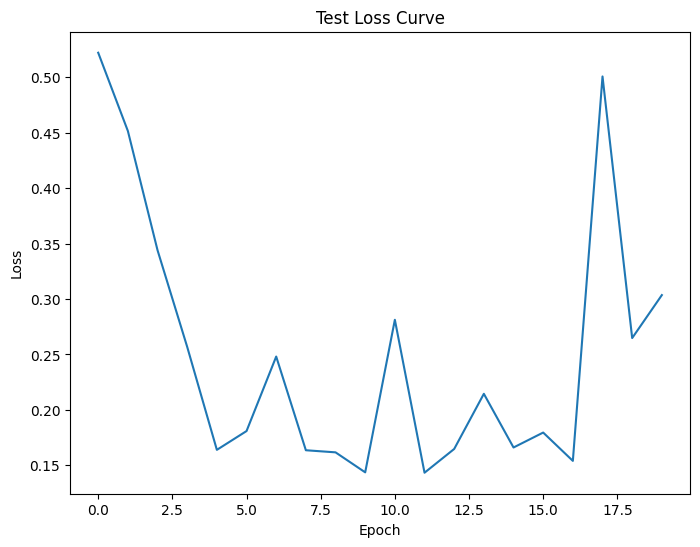

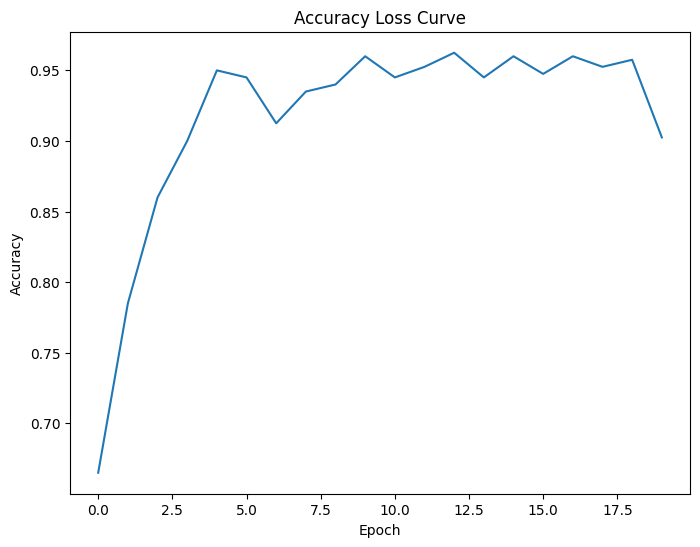

In [19]:
import torchvision.models
save_name = 'resnet18.pth'
# model = LeNet(num_classes=1)
model = torchvision.models.resnet50(pretrained=False,num_classes=1)
model.to('cuda')
train(model, save_name)

In [20]:
# import torchvision.models
# import torch
# # torch.hub.list('B-cos/B-cos-v2')
# save_name = 'B-cos.pth'
# # model = LeNet(num_classes=1)
# model = torch.hub.load('B-cos/B-cos-v2', 'resnet18', pretrained=False,num_classes=1

# model.to('cuda')
# train(model, save_name)

In [21]:
import numpy as np
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
import numpy as np


class NormedConv2d(nn.Conv2d):
    """
    Standard 2D convolution, but with unit norm weights.
    """

    def forward(self, in_tensor):
        shape = self.weight.shape
        w = self.weight.view(shape[0], -1)
        w = w/(w.norm(p=2, dim=1, keepdim=True))
        return F.conv2d(in_tensor, w.view(shape),
                        self.bias, self.stride, self.padding, self.dilation, self.groups)


class BcosConv2d(nn.Module):

    def __init__(self, inc, outc, kernel_size=1, stride=1, padding=0, max_out=2, b=2,
                 scale=None, scale_fact=100, **kwargs):
        super().__init__()
        
        ks = kernel_size
        self.stride = stride
        self.linear = NormedConv2d(inc, outc * max_out, ks, stride, padding, 1, 1, bias=False)
        self.outc = outc * max_out
        self.b = b
        self.max_out = max_out
        self.inc = inc
        self.kernel_size = ks
        self.kssq = ks**2 if not isinstance(ks, tuple) else np.prod(ks)
        self.padding = padding
        self.detach = False
        if scale is None:
            ks_scale = ks if not isinstance(ks, tuple) else np.sqrt(np.prod(ks))
            self.scale = (ks_scale * np.sqrt(self.inc)) / scale_fact
        else:
            self.scale = scale

    def forward(self, in_tensor):
        """
        In the case of B=2, we do not have to explicitly calculate the cosine term.
        Args:
            in_tensor: Input tensor. Expected shape: (B, C, H, W)

        Returns:
            BcosConv2d output on the input tensor.
        """
        if self.b == 2:
            return self.fwd_2(in_tensor)
        return self.fwd_b(in_tensor)

    def explanation_mode(self, detach=True):
        """
        Enter 'explanation mode' by setting self.explain and self.detach.
        Args:
            detach: Whether to 'detach' the weight matrix from the computational graph so that it is not
                            taken into account in the backward pass.

        Returns: None

        """
        self.detach = detach

    def fwd_b(self, in_tensor):
        # Simple linear layer
        out = self.linear(in_tensor)
        bs, _, h, w = out.shape

        # MaxOut computation
        if self.max_out > 1:
            bs, _, h, w = out.shape
            out = out.view(bs, -1, self.max_out, h, w)
            out = out.max(dim=2, keepdim=False)[0]

        # If B=1, no further calculation necessary.
        if self.b == 1:
            return out / self.scale

        # Calculating the norm of input patches. Use average pooling and upscale by kernel size.
        norm = (F.avg_pool2d((in_tensor ** 2).sum(1, keepdim=True), self.kernel_size, padding=self.padding,
                             stride=self.stride) * self.kssq + 1e-6  # stabilising term
                ).sqrt_()

        # get absolute value of cos
        # TODO: unnecessary doubling of stabilising term. Only affects CIFAR10 experiments in the paper.
        abs_cos = (out / norm).abs() + 1e-6

        # In order to compute the explanations, we detach the dynamically calculated scaling from the graph.
        if self.detach:
            abs_cos = abs_cos.detach()

        # additional factor of cos^(b-1) s.t. in total we have norm * cos^b with original sign
        out = out * abs_cos.pow(self.b-1)
        return out / self.scale

    def fwd_2(self, in_tensor):
        # Simple linear layer
        out = self.linear(in_tensor)
#         print('in_tensor',in_tensor.size(),'out',out.size())
        # MaxOut computation
        if self.max_out > 1:
            bs, _, h, w = out.shape
#             out = out.view(bs, -1, self.max_out, h, w)
            out = out.view(bs, -1, self.max_out, h, w)
    
            out = out.max(dim=2, keepdim=False)[0]
#             print(out.size())
        # Calculating the norm of input patches. Use average pooling and upscale by kernel size.
        # TODO: implement directly as F.sum_pool2d...
        norm = (F.avg_pool2d((in_tensor ** 2).sum(1, keepdim=True), self.kernel_size, padding=self.padding,
                                    stride=self.stride) * self.kssq + 1e-6  # stabilising term
                ).sqrt_()

        # In order to compute the explanations, we detach the dynamically calculated scaling from the graph.
        if self.detach:
            out = (out * out.abs().detach())
            norm = norm.detach()
        else:
            out = (out * out.abs())

        return out / (norm * self.scale)

# from torchvision.models.utils import load_state_dict_from_url
from torch.hub import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, dilation: int = 1) -> BcosConv2d:
    """3x3 convolution with padding"""
    return BcosConv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> BcosConv2d:
    """1x1 convolution"""
    return BcosConv2d(in_planes, out_planes, kernel_size=1, stride=stride)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        short_cat=False
    ) -> None:
        super(BasicBlock, self).__init__()
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.conv2 = conv3x3(planes, planes)
        self.downsample = downsample
        self.stride = stride
        self.short_cat = BcosConv2d(2 * planes, planes) if short_cat else None

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)

        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        if self.short_cat is not None:
            out = self.short_cat(torch.cat([out, identity], dim=1))
        else:
            out += identity

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        short_cat = False
    ) -> None:
        super(Bottleneck, self).__init__()
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.conv2 = conv3x3(width, width, stride)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.downsample = downsample
        self.stride = stride
        self.short_cat = BcosConv2d(2 * planes * self.expansion, planes * self.expansion) if short_cat else None

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        if self.short_cat is not None:
            out = self.short_cat(torch.cat([out, identity], dim=1))
        else:
            out += identity

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        short_cat: bool = False
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.short_cat = short_cat
        self.base_width = width_per_group
#         self.conv1 = BcosConv2d(6, self.inplanes, kernel_size=7, stride=2, padding=3)
        self.conv1 = BcosConv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3)
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.fc = BcosConv2d(512 * block.expansion, num_classes)
#         print('block.expansion',block.expansion)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def get_features(self, x):
        return self.get_sequential_model()[:-1](x)

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer, self.short_cat))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def get_sequential_model(self):
        model = nn.Sequential(
            self.conv1,
            self.avgpool,
            *[m for m in self.layer1],
            *[m for m in self.layer2],
            *[m for m in self.layer3],
            *[m for m in self.layer4],
            self.fc
        )
        return model

    def get_layer_idx(self, idx):
        return int(np.ceil(len(self.get_sequential_model())*idx/10))

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
#         print(x.size())
        x = self.conv1(x)
        x = self.avgpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.fc(x)
        linear_layer = nn.Linear(in_features=7*7, out_features=1).cuda()

        x_out = linear_layer(x.view(10, -1))
        return x_out

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


In [22]:
# import torchvision.models
# import torch
# # torch.hub.list('B-cos/B-cos-v2')
# save_name = 'B-cos.pth'
# # model = LeNet(num_classes=1)
# # model = torch.hub.load('B-cos/B-cos-v2', 'resnet18', pretrained=False,num_classes=1
# model = resnet18(pretrained=False,num_classes=1)

# model.to('cuda')
# train(model, save_name)